In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import ast
from geopy.distance import geodesic as GD
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from category_encoders import TargetEncoder
import sklearn

In [2]:
data_2015=pd.read_csv(r'C:\Users\Kfoury\Downloads\2015_building_energy_benchmarking\2015_building_energy_benchmarking.csv')
data_2016=pd.read_csv(r'C:\Users\Kfoury\Downloads\2016_building_energy_benchmarking\2016_building_energy_benchmarking.csv')

# Comparaison 2015 et 2016

In [3]:
NOT_2015=[]
Commun=[]
NOT_2016=[]

for column in data_2016.columns:
    
    if column not in(data_2015.columns):
        NOT_2015.append(column)  
    else:
        Commun.append(column)

for column in data_2015.columns:
    if column not in(data_2016.columns):
        NOT_2016.append(column)  
print('Les colonnes 2016 et pas 2015:',NOT_2015)

print('Les colonnes communes pour 2015 et 2016:',Commun)

print('Les colonnes 2015 et pas 2016:',NOT_2016)     

Les colonnes 2016 et pas 2015: ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
Les colonnes communes pour 2015 et 2016: ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceSt

### Transfomation de la colonne 'Location' en plusieurs colonnes

In [4]:
dict_trans=data_2015['Location'].apply(ast.literal_eval)
for i in range(len(data_2015)):
    data_2015.loc[i,'Latitude']=dict_trans[i]['latitude']
    data_2015.loc[i,'Longitude']=dict_trans[i]['longitude']
    data_2015.loc[i,'human_address']=dict_trans[i]['human_address']
dict_trans=data_2015['human_address'].apply(ast.literal_eval)
for i in range(len(data_2015)):
    data_2015.loc[i,'Address']=dict_trans[i]['address']
    data_2015.loc[i,'City']=dict_trans[i]['city']
    data_2015.loc[i,'State']=dict_trans[i]['state']
    data_2015.loc[i,'ZipCode']=dict_trans[i]['zip']
data_2015.drop('Location',inplace=True,axis=1)    
data_2015.drop('human_address',inplace=True,axis=1)  

In [5]:
data_2015[['Street_number','Street_name']] = data_2015['Address'].str.split(n=1, expand=True)

In [6]:
data=pd.concat([data_2015,data_2016],axis=0)

### Differentes nomenclatures de la colonne émission (en 2015 et 2016)

In [7]:
print(data['GHGEmissions(MetricTonsCO2e)'].describe())
print(data['TotalGHGEmissions'].describe())

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64
count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64


In [8]:
data[['TotalGHGEmissions']].fillna(data[['GHGEmissions(MetricTonsCO2e)','TotalGHGEmissions']].mean(axis=1),inplace=True)

In [9]:
data.drop('GHGEmissions(MetricTonsCO2e)',axis=1,inplace=True)

In [10]:
data.dtypes

OSEBuildingID                                                      int64
DataYear                                                           int64
BuildingType                                                      object
PrimaryPropertyType                                               object
PropertyName                                                      object
TaxParcelIdentificationNumber                                     object
CouncilDistrictCode                                                int64
Neighborhood                                                      object
YearBuilt                                                          int64
NumberofBuildings                                                float64
NumberofFloors                                                   float64
PropertyGFATotal                                                   int64
PropertyGFAParking                                                 int64
PropertyGFABuilding(s)                             

In [11]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier',
       '20

In [12]:
Quantitative=['OSEBuildingID',
             'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
             'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA',
             'ThirdLargestPropertyUseTypeGFA','ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
             'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 
             'SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
             'Electricity(kWh)','Electricity(kBtu)', 'NaturalGas(therms)',
             'NaturalGas(kBtu)','OtherFuelUse(kBtu)',
             'GHGEmissionsIntensity(kgCO2e/ft2)','TotalGHGEmissions', 'GHGEmissionsIntensity']
Qualitative=['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType',
       'YearsENERGYSTARCertified',
       'DefaultData', 'Comment',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes', 'Latitude',
       'Longitude', 'Street_name', 'City', 'State', 'ZipCode', 'Comments']

In [13]:
Quant_data=data[Quantitative]
Qual_data=data[Qualitative]


In [14]:
Quant_groupby=Quant_data.groupby('OSEBuildingID').mean()
Qual_groupby=Qual_data.groupby('OSEBuildingID').last()
df=pd.merge(Quant_groupby,Qual_groupby, left_index=True, right_index=True)

In [15]:
for i in df.index:
    df.loc[i,'Distance_From_Center']=GD((df.loc[i,'Latitude'], df.loc[i,'Longitude']),(+47.62198, -122.35166)).km

In [16]:
df['Age']=2016-df['YearBuilt']

In [17]:
df.isna().mean()

PropertyGFATotal                                                 0.000000
PropertyGFAParking                                               0.000000
PropertyGFABuilding(s)                                           0.000000
LargestPropertyUseTypeGFA                                        0.008741
SecondLargestPropertyUseTypeGFA                                  0.503497
ThirdLargestPropertyUseTypeGFA                                   0.823135
ENERGYSTARScore                                                  0.226107
SiteEUI(kBtu/sf)                                                 0.000874
SiteEUIWN(kBtu/sf)                                               0.000874
SourceEUI(kBtu/sf)                                               0.001166
SourceEUIWN(kBtu/sf)                                             0.001166
SiteEnergyUse(kBtu)                                              0.000874
SiteEnergyUseWN(kBtu)                                            0.000874
SteamUse(kBtu)                        

**Nombre de valeures nulles des colonnes *TotalGHGEmissions* et *SiteEnergyUse(kBtu)***

In [18]:
df[(df['TotalGHGEmissions']<=0) |(df['SiteEnergyUse(kBtu)']<=0)].shape

(11, 54)

In [19]:
df=df[df['TotalGHGEmissions']>0]
df=df[df['SiteEnergyUse(kBtu)']>0]

## Y vs log(Y)

In [20]:
Z1=df[['SiteEnergyUse(kBtu)']]
Z1=(Z1-Z1.mean())/((Z1.std())**2)
Z1.describe()

,SiteEnergyUse(kBtu)
count,3.356000e+03
mean,8.412792e-24
std,4.636447e-08
min,-1.156126e-08
25%,-9.581360e-09
50%,-7.701663e-09
75%,-2.515748e-09
max,1.867052e-06


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

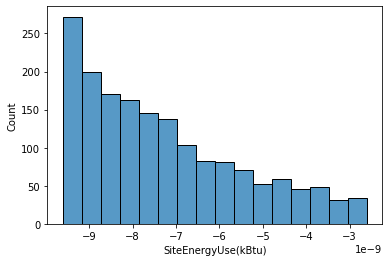

In [21]:
Z1=Z1[(Z1['SiteEnergyUse(kBtu)']<-2.579015e-09)&(Z1['SiteEnergyUse(kBtu)']>-9.616264e-09)]['SiteEnergyUse(kBtu)']
sns.histplot(Z1)


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

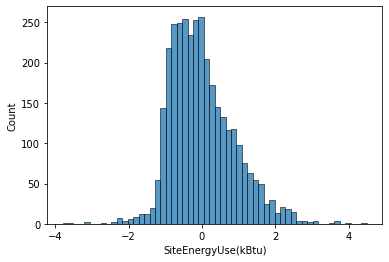

In [22]:
Z=np.log(df['SiteEnergyUse(kBtu)'])
Z=(Z-Z.mean())/((Z.std())**2)
sns.histplot(Z)

In [23]:
T1=df[['TotalGHGEmissions']]
T1=(T1-T1.mean())/((T1.std())**2)
T1.describe()

,TotalGHGEmissions
count,3.356000e+03
mean,4.024568e-19
std,1.852980e-03
min,-4.121111e-04
25%,-3.793037e-04
50%,-2.954740e-04
75%,-8.890407e-05
max,5.751465e-02


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

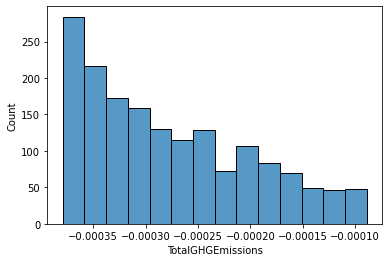

In [24]:
T1=T1[(T1['TotalGHGEmissions']<-8.881411e-05)&(T1['TotalGHGEmissions']>-3.793389e-04)]['TotalGHGEmissions']
sns.histplot(T1)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

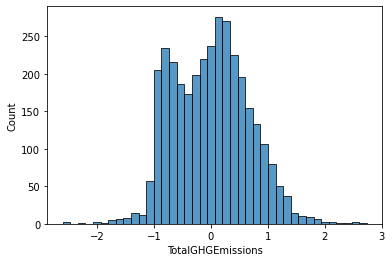

In [90]:
T=np.log(df['TotalGHGEmissions'])
T=(T-T.mean())/((T.std())**2)
sns.histplot(T)

In [26]:
df.isna().mean()

PropertyGFATotal                                                 0.000000
PropertyGFAParking                                               0.000000
PropertyGFABuilding(s)                                           0.000000
LargestPropertyUseTypeGFA                                        0.001788
SecondLargestPropertyUseTypeGFA                                  0.499106
ThirdLargestPropertyUseTypeGFA                                   0.821216
ENERGYSTARScore                                                  0.224374
SiteEUI(kBtu/sf)                                                 0.000000
SiteEUIWN(kBtu/sf)                                               0.000000
SourceEUI(kBtu/sf)                                               0.000000
SourceEUIWN(kBtu/sf)                                             0.000000
SiteEnergyUse(kBtu)                                              0.000000
SiteEnergyUseWN(kBtu)                                            0.000000
SteamUse(kBtu)                        

In [27]:
DF=df[['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA','BuildingType','ENERGYSTARScore',
       'PrimaryPropertyType','CouncilDistrictCode', 'Neighborhood', 'Age', 'NumberofBuildings',
       'NumberofFloors','LargestPropertyUseType','Distance_From_Center','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

In [28]:
DF.isna().mean()

PropertyGFATotal             0.000000
PropertyGFAParking           0.000000
PropertyGFABuilding(s)       0.000000
LargestPropertyUseTypeGFA    0.001788
BuildingType                 0.000000
ENERGYSTARScore              0.224374
PrimaryPropertyType          0.000000
CouncilDistrictCode          0.000000
Neighborhood                 0.000000
Age                          0.000000
NumberofBuildings            0.000000
NumberofFloors               0.000000
LargestPropertyUseType       0.001788
Distance_From_Center         0.000000
TotalGHGEmissions            0.000000
SiteEnergyUse(kBtu)          0.000000
dtype: float64

In [29]:
DF=DF.dropna(axis=0,subset=['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA','BuildingType','PrimaryPropertyType','CouncilDistrictCode', 
        'Neighborhood', 'Age', 'NumberofBuildings','NumberofFloors','LargestPropertyUseType',
        'Distance_From_Center','TotalGHGEmissions','SiteEnergyUse(kBtu)'])

# Nettoyage des colonnes

In [30]:
DF['BuildingType'].value_counts()

NonResidential          1450
Multifamily LR (1-4)    1007
Multifamily MR (5-9)     580
Multifamily HR (10+)     109
SPS-District K-12         94
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

On enlève les types d'immeubles **Multifamily**.

In [31]:
DF=DF[~(DF['BuildingType'].str.contains('Multifamily'))]

In [32]:
DF.loc[:,'BuildingType']=DF.loc[:,'BuildingType'].replace(to_replace='Nonresidential WA', value='Nonresidential')
DF.loc[:,'BuildingType']=DF.loc[:,'BuildingType'].replace(to_replace='Nonresidential COS', value='Nonresidential')


In [33]:
DF['PrimaryPropertyType'].value_counts()


Small- and Mid-Sized Office    289
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    135
Mixed Use Property             113
Retail Store                    91
Hotel                           75
Worship Facility                71
Distribution Center             53
Medical Office                  39
Supermarket / Grocery Store     39
Self-Storage Facility           27
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [34]:
DF=DF[~(DF['PrimaryPropertyType'].str.contains('Multifamily'))]

In [35]:
DF.loc[:,'PrimaryPropertyType']=DF.loc[:,'PrimaryPropertyType'].replace(to_replace='Small- and Mid-Sized Office', value='Office')
DF.loc[:,'PrimaryPropertyType']=DF.loc[:,'PrimaryPropertyType'].replace(to_replace='Large Office', value='Office')
DF.loc[:,'PrimaryPropertyType']=DF.loc[:,'PrimaryPropertyType'].replace(to_replace='Restaurant\n', value='Restaurant')
DF.loc[:,'PrimaryPropertyType']=DF.loc[:,'PrimaryPropertyType'].replace(to_replace='Refrigerated Warehouse', value='Warehouse')
DF.loc[:,'PrimaryPropertyType']=DF.loc[:,'PrimaryPropertyType'].replace(to_replace='Non-Refrigerated Warehouse', value='Warehouse')

In [36]:
DF['Neighborhood'].value_counts()

DOWNTOWN                  356
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     150
LAKE UNION                146
NORTHEAST                 127
EAST                      120
NORTHWEST                  80
BALLARD                    63
NORTH                      56
CENTRAL                    50
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  40
North                       9
Ballard                     6
Northwest                   5
Delridge                    4
Central                     4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

In [37]:
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='North', value='NORTH')
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='Central', value='CENTRAL')
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='Northwest', value='NORTHWEST')
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='Ballard', value='BALLARD')
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='Delridge', value='DELRIDGE')
DF.loc[:,'Neighborhood']=DF.loc[:,'Neighborhood'].replace(to_replace='DELRIDGE NEIGHBORHOODS', value='DELRIDGE')

In [53]:
DF[['TotalGHGEmissions']].describe()

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,Distance_From_Center,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1.651000e+03,1651.000000,1.651000e+03,1.651000e+03,1127.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1.651000e+03
mean,1.185390e+05,13308.354331,1.052306e+05,9.848969e+04,64.800355,4.353119,54.078740,1.169594,4.131435,4.887638,186.464518,8.457250e+06
std,2.968633e+05,42159.406256,2.825489e+05,2.768143e+05,28.122726,2.193811,32.699734,2.944591,6.593315,3.251350,755.212943,3.025025e+07
min,1.128500e+04,-1.000000,-8.451000e+03,6.455000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,0.143932,0.120000,1.697945e+04
25%,2.940850e+04,0.000000,2.838250e+04,2.550000e+04,46.250000,2.000000,27.000000,1.000000,1.000000,2.219946,20.235000,1.235373e+06
50%,4.929900e+04,0.000000,4.741500e+04,4.349500e+04,72.500000,4.000000,51.000000,1.000000,2.000000,4.241089,49.980000,2.559644e+06
75%,1.074480e+05,0.000000,9.574800e+04,9.197050e+04,88.000000,7.000000,86.000000,1.000000,4.000000,7.063187,144.600000,7.040798e+06
max,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,100.000000,7.000000,116.000000,111.000000,99.000000,15.195295,16870.980000,8.739237e+08


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

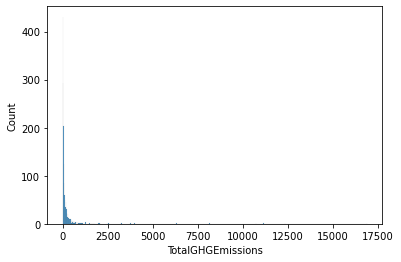

In [66]:
sns.histplot(DF['TotalGHGEmissions'])

In [69]:
DF[DF['TotalGHGEmissions']<1000].describe()

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,Distance_From_Center,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1.610000e+03,1610.000000,1.610000e+03,1.610000e+03,1105.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1.610000e+03
mean,1.027073e+05,12960.751242,8.974652e+04,8.306195e+04,65.162896,4.342236,54.329193,1.078882,4.001863,4.935599,108.802168,5.832343e+06
std,1.692906e+05,41909.900526,1.421115e+05,1.322216e+05,28.042656,2.197296,32.671515,1.076035,6.459560,3.258583,150.176731,9.124512e+06
min,1.128500e+04,-1.000000,-8.451000e+03,6.455000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,0.143932,0.120000,1.697945e+04
25%,2.901975e+04,0.000000,2.808725e+04,2.509700e+04,47.000000,2.000000,27.000000,1.000000,1.000000,2.300338,19.812500,1.207011e+06
50%,4.800350e+04,0.000000,4.606350e+04,4.221150e+04,73.500000,4.000000,51.000000,1.000000,2.000000,4.398792,48.705000,2.475102e+06
75%,9.943825e+04,0.000000,8.987500e+04,8.480600e+04,88.500000,7.000000,86.000000,1.000000,4.000000,7.102376,130.205000,6.518690e+06
max,1.952220e+06,512608.000000,1.632820e+06,1.680937e+06,100.000000,7.000000,116.000000,27.000000,99.000000,15.195295,940.470000,9.374886e+07


In [70]:
DF=DF[DF['TotalGHGEmissions']<1000]

In [71]:
X=DF.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'],axis=1)
Y=DF[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

<AxesSubplot:>

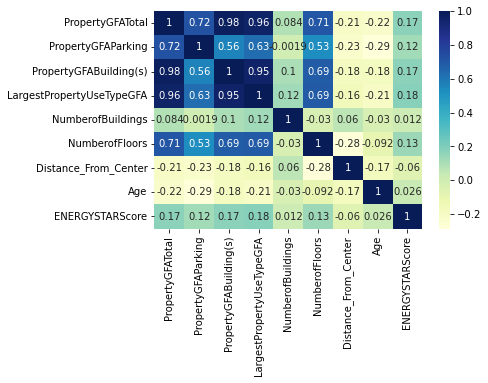

In [72]:
X_quant=DF[['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',
       'NumberofBuildings',
       'NumberofFloors','Distance_From_Center','Age','ENERGYSTARScore']]
sns.heatmap(X_quant.astype('float').corr(),cmap="YlGnBu",annot=True)

In [73]:
X.loc[:,'RelPropertyGFAParking']=X['PropertyGFAParking']/X['PropertyGFATotal']
X.loc[:,'RelPropertyGFABuilding(s)']=X['PropertyGFABuilding(s)']/X['PropertyGFATotal']
X.loc[:,'PropertyGFATotalPerBuild']=X['PropertyGFATotal']/X['NumberofBuildings']
X.loc[:,'PropertyGFATotalPerFloor']=X['PropertyGFATotal']/X['NumberofFloors']

<AxesSubplot:>

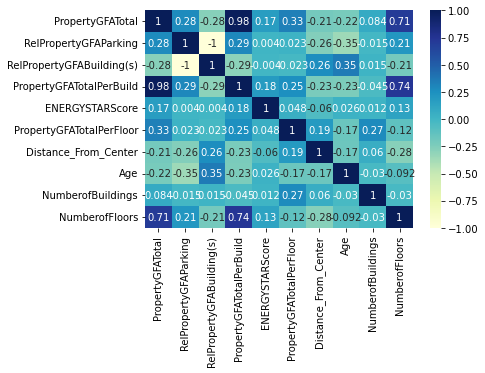

In [74]:
X_quant=X[['PropertyGFATotal', 'RelPropertyGFAParking','RelPropertyGFABuilding(s)',
        
       'PropertyGFATotalPerBuild','ENERGYSTARScore',
       'PropertyGFATotalPerFloor','Distance_From_Center','Age','NumberofBuildings','NumberofFloors']]
sns.heatmap(X_quant.corr(),cmap="YlGnBu",annot=True)

In [75]:
X.columns

Index(['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'BuildingType', 'ENERGYSTARScore',
       'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'Age',
       'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseType',
       'Distance_From_Center', 'RelPropertyGFAParking',
       'RelPropertyGFABuilding(s)', 'PropertyGFATotalPerBuild',
       'PropertyGFATotalPerFloor'],
      dtype='object')

In [76]:
X_quali=X[['Neighborhood','CouncilDistrictCode','BuildingType','PrimaryPropertyType','LargestPropertyUseType']]

In [77]:
X.describe()

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,Distance_From_Center,RelPropertyGFAParking,RelPropertyGFABuilding(s),PropertyGFATotalPerBuild,PropertyGFATotalPerFloor
count,1.610000e+03,1610.000000,1.610000e+03,1.610000e+03,1105.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.0,1610.00000
mean,1.027073e+05,12960.751242,8.974652e+04,8.306195e+04,65.162896,4.342236,54.329193,1.078882,4.001863,4.935599,0.062293,0.937707,inf,inf
std,1.692906e+05,41909.900526,1.421115e+05,1.322216e+05,28.042656,2.197296,32.671515,1.076035,6.459560,3.258583,0.139101,0.139101,NaN,NaN
min,1.128500e+04,-1.000000,-8.451000e+03,6.455000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,0.143932,-0.000015,-0.251159,4300.0,221.69697
25%,2.901975e+04,0.000000,2.808725e+04,2.509700e+04,47.000000,2.000000,27.000000,1.000000,1.000000,2.300338,0.000000,1.000000,28800.0,13200.00000
50%,4.800350e+04,0.000000,4.606350e+04,4.221150e+04,73.500000,4.000000,51.000000,1.000000,2.000000,4.398792,0.000000,1.000000,48003.5,22779.00000
75%,9.943825e+04,0.000000,8.987500e+04,8.480600e+04,88.500000,7.000000,86.000000,1.000000,4.000000,7.102376,0.000000,1.000000,103857.5,37492.56250
max,1.952220e+06,512608.000000,1.632820e+06,1.680937e+06,100.000000,7.000000,116.000000,27.000000,99.000000,15.195295,1.251159,1.000015,inf,inf


In [78]:
X.replace([np.inf, -np.inf], 0, inplace=True)

In [79]:
Y.describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1610.000000,1.610000e+03
mean,108.802168,5.832343e+06
std,150.176731,9.124512e+06
min,0.120000,1.697945e+04
25%,19.812500,1.207011e+06
50%,48.705000,2.475102e+06
75%,130.205000,6.518690e+06
max,940.470000,9.374886e+07


## EnergyStarScore NaN treatment

In [80]:
DF_ENERGYSTARScore=pd.merge(X,Y,left_index=True,right_index=True).dropna(axis=0)

In [81]:
DF_ENERGYSTARScore.shape

(1105, 20)

In [82]:
X_ENERGYSTARScore=DF_ENERGYSTARScore.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
Y_ENERGYSTARScore=DF_ENERGYSTARScore[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

In [83]:
X_ENERGYSTARScore.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\X_ENERGYSTARScore.csv')
Y_ENERGYSTARScore.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\Y_ENERGYSTARScore.csv')

## Save as csv

In [84]:
X.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\X.csv',index=False)
Y.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\Y.csv',index=False)
X_ENERGYSTARScore.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\X_ENERGYSTARScore.csv',index=False)
Y_ENERGYSTARScore.to_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\Y_ENERGYSTARScore.csv',index=False)

In [87]:
X.head()

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,BuildingType,ENERGYSTARScore,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,LargestPropertyUseType,Distance_From_Center,RelPropertyGFAParking,RelPropertyGFABuilding(s),PropertyGFATotalPerBuild,PropertyGFATotalPerFloor
OSEBuildingID,,,,,,,,,,,,,,,,,,
1,88434.0,0.0,88434.0,88434.0,NonResidential,62.5,Hotel,7,DOWNTOWN,89,1.0,12.0,Hotel,1.496143,0.000000,1.000000,88434.0,7369.500000
2,103566.0,15064.0,88502.0,83880.0,NonResidential,56.0,Hotel,7,DOWNTOWN,20,1.0,11.0,Hotel,1.654076,0.145453,0.854547,103566.0,9415.090909
5,61320.0,0.0,61320.0,61320.0,NonResidential,28.5,Hotel,7,DOWNTOWN,90,1.0,10.0,Hotel,1.427800,0.000000,1.000000,61320.0,6132.000000
8,147735.0,37230.0,110505.0,123445.0,NonResidential,71.0,Hotel,7,DOWNTOWN,36,1.0,18.0,Hotel,1.242947,0.252005,0.747995,147735.0,8207.500000
9,97288.0,37198.0,60090.0,88830.0,Nonresidential,NaN,Other,7,DOWNTOWN,17,1.0,2.0,Police Station,1.302106,0.382349,0.617651,97288.0,48644.000000


<AxesSubplot:>

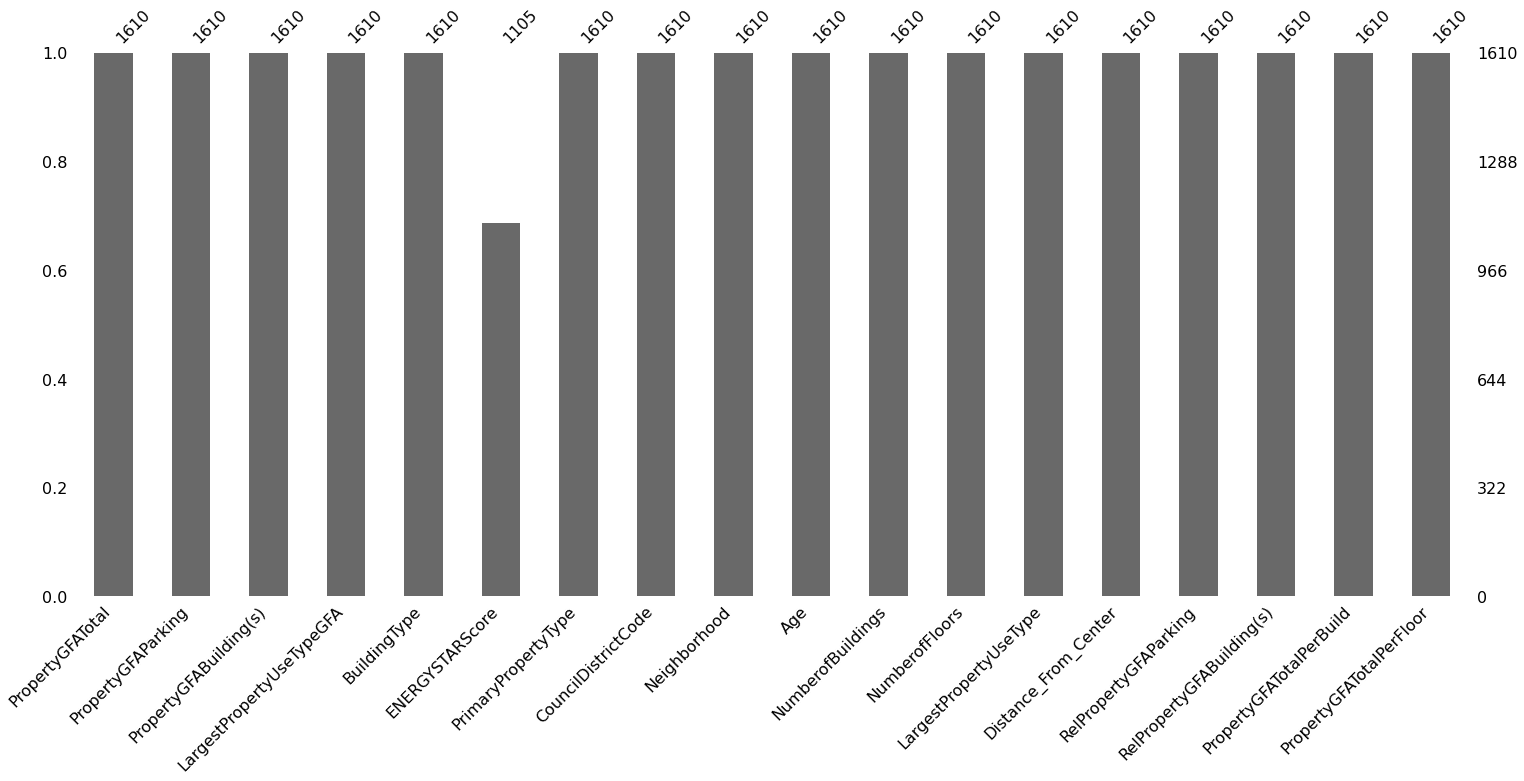

In [88]:
missingno.bar(X)